# ADAMS Assignment Task: Medium Claps Prediction

### Yagmur Dalman

## Introduction 

Medium is a blogging platform with a variety of topics and authors. It is initially developed to publish writings and documents longer than Twitter's 140-character maximum by  Evan Williams[1]. Unlike the other platforms like Twitter and Facebook, instead of like button there is a clap button for each article in Medium. 

Our motivation is that number of claps can be one measure for the success of a post so in this task, we will be predicting the number of claps that an article is going to get based on its text and statistics. 

We have two different datasets named as Train and Test. In the train dataset there are 50 column including number of claps, text, title, author, number of responses, publication details etc.  The columns of the training and the test set are not identical. So we aim to create some more feautes for the test data. Our task is to predict the number of claps of the posts of the test set. 

For the text analysis we use Natural language processing (NLP) that provides algorithms to find the interaction between computers and humans using the natural language. We start with cleaning our text, tokenize it by separating it into individual words and then use lemmatization to reduce a word to its lemma. Then, for the vector representation of the words we create word embeddings using Word2Vec[2].

We use Keras functional API to create a model with multiple inputs and mixed data. By this term we refer to combination of textual and numerical/categorical data. It consists of two branches; the first one is Multi-layer Perceptron (MLP) and it takes umerical features as input and the second one is Convolutional Neural Network (CNN) with the text input. Then I concatenate these networks together to form the final multi-input Keras model[3]. 

For NLP tasks RNNs are widely used while CNNs are mostly used for image classification. Since CNNs are much faster we use CNN even though, RNNs have better performance.



In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sb 

%matplotlib inline

# Handling html
from bs4 import BeautifulSoup

# Regular expressions
import re

# Standard NLP workflow
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

# Saving and loading objects
import pickle

In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('wordnet')

### Load and Explore Data 


In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv', index_col=[0]) # because of the Unnamed:0 column
sample = pd.read_csv('Sample_submission.csv')


There are 3 data files provided. Our target value the number of claps is included in the Train.csv file in the column: TotalClapCount and also the article texts in the column: text which are the subject of NLP. In addition, the training data contains some other feautes of the posts like length of a post, number of responses, number of recommendations, urls etc. There are 50 columns in total.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279577 entries, 0 to 279576
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   audioVersionDurationSec      279577 non-null  int64  
 1   codeBlock                    25179 non-null   object 
 2   codeBlockCount               279577 non-null  float64
 3   collectionId                 137878 non-null  object 
 4   createdDate                  279577 non-null  object 
 5   createdDatetime              279577 non-null  object 
 6   firstPublishedDate           279577 non-null  object 
 7   firstPublishedDatetime       279577 non-null  object 
 8   imageCount                   279577 non-null  int64  
 9   isSubscriptionLocked         279577 non-null  bool   
 10  language                     279577 non-null  object 
 11  latestPublishedDate          279577 non-null  object 
 12  latestPublishedDatetime      279577 non-null  object 
 13 

First, we create a column as named ElapsedTime in the train data frame for the duration between first published dates and the scraped date of the posts.

In [5]:
train['firstPublishedDate']= pd.to_datetime(train['firstPublishedDate']) 

In [6]:
train['firstPublishedDate'].head()

0   2018-09-18
1   2018-09-18
2   2018-09-18
3   2018-01-07
4   2018-01-07
Name: firstPublishedDate, dtype: datetime64[ns]

In [7]:
train['scrappedDate'] = pd.to_datetime(train['scrappedDate'].astype(str), format='%Y%m%d')

train['scrappedDate'].head()

0   2018-11-04
1   2018-11-04
2   2018-11-04
3   2018-11-04
4   2018-11-04
Name: scrappedDate, dtype: datetime64[ns]

In [8]:
train['ElapsedTime'] = (train.scrappedDate - train.firstPublishedDate).dt.days

train['ElapsedTime'].head()

0     47
1     47
2     47
3    301
4    301
Name: ElapsedTime, dtype: int64

In [9]:
pd.set_option('max_colwidth', 30) 

train.head(10)

audioVersionDurationSec codeBlock  codeBlockCount  collectionId  \
0                        0       NaN             0.0  638f418c8464   
1                        0       NaN             0.0  638f418c8464   
2                        0       NaN             0.0  638f418c8464   
3                        0       NaN             0.0           NaN   
4                        0       NaN             0.0           NaN   
5                        0       NaN             0.0           NaN   
6                        0       NaN             0.0           NaN   
7                        0       NaN             0.0           NaN   
8                        0       NaN             0.0           NaN   
9                        0       NaN             0.0           NaN   

  createdDate      createdDatetime firstPublishedDate firstPublishedDatetime  \
0  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
1  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
2  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
3  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
4  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
5  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
6  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
7  2018-03-08  2018-03-08 07:04:31         2018-03-08    2018-03-08 07:07:42   
8  2018-03-08  2018-03-08 07:04:31         2018-03-08    2018-03-08 07:07:42   
9  2018-03-08  2018-03-08 07:04:31         2018-03-08    2018-03-08 07:07:42   

   imageCount  isSubscriptionLocked  ...                    name postCount  \
0           1                 False  ...              Blockchain  265164.0   
1           1                 False  ...                 Samsung    5708.0   
2           1                 False  ...                      It    3720.0   
3          13                 False  ...              Technology  166125.0   
4          13                 False  ...                Robotics    9103.0   
5          13                 False  ...              Automation    9007.0   
6          13                 False  ...                     Epq       8.0   
7           1                 False  ...            Data Science   33617.0   
8           1                 False  ...    Sas Training In Pune      33.0   
9           1                 False  ...  Hadoop Training Mumbai       3.0   

         author                            bio        userId  \
0   Anar Babaev                            NaN  f1ad85af0169   
1   Anar Babaev                            NaN  f1ad85af0169   
2   Anar Babaev                            NaN  f1ad85af0169   
3  George Sykes                            NaN  93b9e94f08ca   
4  George Sykes                            NaN  93b9e94f08ca   
5  George Sykes                            NaN  93b9e94f08ca   
6  George Sykes                            NaN  93b9e94f08ca   
7     tech data  Tech data Providing Course...  60a3bfd83742   
8     tech data  Tech data Providing Course...  60a3bfd83742   
9     tech data  Tech data Providing Course...  60a3bfd83742   

              userName  usersFollowedByCount  usersFollowedCount  \
0           babaevanar                 450.0               404.0   
1           babaevanar                 450.0               404.0   
2           babaevanar                 450.0               404.0   
3             tasty231                   6.0                22.0   
4             tasty231                   6.0                22.0   
5             tasty231                   6.0                22.0   
6             tasty231                   6.0                22.0   
7  techdatasolutions18                   4.0                 1.0   
8  techdatasolutions18                   4.0                 1.0   
9  techdatasolutions18                   4.0                 1.0   

   scrappedDate ElapsedTime  
0    201

In [10]:
pd.set_option('max_colwidth', 2000) 

train.text.head(1)

0    Private Business, Government and Blockchain\n\nA major private IT company implements blockchain, artificial intelligence, and Internet of Things to optimize and improve high technology workflow. The representatives of a major state structure from the same country like this experiment so much they decide to use it in their work and conclude an agreement with the IT giant. This is an ideal example of interaction between private business and the state regarding blockchain, don’t you think? What is even better is that this story is real: in South Korea a local customs office has signed the respective partnership agreement with Samsung. I believe that the near-term development of blockchain will be built on just such examples of cooperation. In a world where all the best technological decisions are copied at supersonic speed, one cannot remain behind the trends for long. That’s why I’m confident that blockchain and other crypto technologies will soon be adopted around the world. In the

In [11]:
pd.set_option('max_colwidth', 200) 

train.url.head(10)

0                            https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe
1                            https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe
2                            https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe
3                                                        https://medium.com/s/story/introduction-3-1000c43bcb97
4                                                        https://medium.com/s/story/introduction-3-1000c43bcb97
5                                                        https://medium.com/s/story/introduction-3-1000c43bcb97
6                                                        https://medium.com/s/story/introduction-3-1000c43bcb97
7    https://medium.com/s/story/ascent-of-data-science-sas-and-big-data-analyst-trainings-programs-100139913e4c
8    https://medium.com/s/story/ascent-of-data-science-sas-and-big-data-analyst-trainings-programs-10013

There are obviously duplicate rows. These rows are duplicated based on the tag names, in each duplicated row of a post there is a different tag name.

In [12]:
train.tag_name.head(10)

0                Blockchain
1                   Samsung
2                        It
3                Technology
4                  Robotics
5                Automation
6                       Epq
7              Data Science
8      Sas Training In Pune
9    Hadoop Training Mumbai
Name: tag_name, dtype: object

In [13]:
train.tag_name.value_counts().to_frame()

tag_name
Artificial Intelligence     34473
Machine Learning            29416
Data Science                18276
Deep Learning                6603
Technology                   6450
...                           ...
Places And Culture              1
Set                             1
Capex                           1
Richard Saul Wurman             1
Treeset                         1

[19278 rows x 1 columns]

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 30) 
train.head()

audioVersionDurationSec codeBlock  codeBlockCount  collectionId  \
0                        0       NaN             0.0  638f418c8464   
1                        0       NaN             0.0  638f418c8464   
2                        0       NaN             0.0  638f418c8464   
3                        0       NaN             0.0           NaN   
4                        0       NaN             0.0           NaN   

  createdDate      createdDatetime firstPublishedDate firstPublishedDatetime  \
0  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
1  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
2  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
3  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
4  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   

   imageCount  isSubscriptionLocked language latestPublishedDate  \
0           1                 False       en          2018-09-18   
1           1                 False       en          2018-09-18   
2           1                 False       en          2018-09-18   
3          13                 False       en          2018-01-07   
4          13                 False       en          2018-01-07   

  latestPublishedDatetime  linksCount        postId  readingTime  recommends  \
0     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
1     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
2     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
3     2018-01-07 17:18:38          24  1000c43bcb97    19.716981           0   
4     2018-01-07 17:18:38          24  1000c43bcb97    19.716981           0   

   responsesCreatedCount  socialRecommendsCount  \
0                      0                      0   
1                      0                      0   
2                      0                      0   
3                      0                      0   
4                      0                      0   

                        subTitle  tagsCount                           text  \
0  A major private IT company...          5  Private Business, Governme...   
1  A major private IT company...          5  Private Business, Governme...   
2  A major private IT company...          5  Private Business, Governme...   
3                   Introduction          5  EPQ draft 1 (4844 words)\n...   
4                   Introduction          5  EPQ draft 1 (4844 words)\n...   

                           title  totalClapCount  \
0  Private Business, Governme...             100   
1  Private Business, Governme...             100   
2  Private Business, Governme...             100   
3       EPQ draft 1 (4844 words)               0   
4       EPQ draft 1 (4844 words)               0   

                      uniqueSlug updatedDate      updatedDatetime  \
0  private-business-governmen...  2018-09-18  2018-09-18 20:58:20   
1  private-business-governmen...  2018-09-18  2018-09-18 20:58:20   
2  private-business-governmen...  2018-09-18  2018-09-18 20:58:20   
3    introduction-3-1000c43bcb97  2018-01-07  2018-01-07 17:18:39   
4    introduction-3-1000c43bcb97  2018-01-07  2018-01-07 17:18:39   

                             url   vote  wordCount  \
0  https://medium.com/s/story...  False        201   
1  https://medium.com/s/story...  False        201   
2  https://medium.com/s/story...  False        201   
3  https://medium.com/s/story...  False       4854   
4  https://medium.com/s/story...  False       4854   

          publicationdescription publicationdomain  \
0  ICOBox is the first and th...               NaN   
1  ICOBox is the first and th...               NaN   
2  ICOBox is the first and th...               NaN   
3                            NaN               NaN   
4                            NaN               NaN   

  publicationfacebookPageName  publicationfollowerCount p

In [15]:
train['text'].head()

0    Private Business, Governme...
1    Private Business, Governme...
2    Private Business, Governme...
3    EPQ draft 1 (4844 words)\n...
4    EPQ draft 1 (4844 words)\n...
Name: text, dtype: object

In [16]:
train['language'].unique()

array(['en', 'th', 'ja', 'zh', 'ru', 'pt', 'es', 'zh-Hant', 'id', 'my',
       'de', 'tr', 'fr', 'ko', 'it', 'lo', 'un', 'vi', 'cs', 'sk', 'is',
       'sv', 'bn', 'mn', 'da', 'no', 'bg', 'ar', 'pl', 'nl', 'ro', 'ca',
       'hu', 'hi', 'ka', 'el', 'ms', 'uk', 'si', 'sr', 'lt', 'la', 'fa',
       'ml', 'sl', 'mr', 'az', 'lv', 'te', 'mk', 'nn', 'fi'], dtype=object)

The posts are written in multiple languages, but I will only consider the english articles.

In [17]:
train['totalClapCount'].head()

0    100
1    100
2    100
3      0
4      0
Name: totalClapCount, dtype: int64

In [18]:
train['tag_name'].head()

0    Blockchain
1       Samsung
2            It
3    Technology
4      Robotics
Name: tag_name, dtype: object

In [19]:
train['readingTime'].head()

0     0.958491
1     0.958491
2     0.958491
3    19.716981
4    19.716981
Name: readingTime, dtype: float64

After checking websites of the posts and we saw that readingTime should be round up to an integer.

### Quality and Tidiness Issues of Train Data
First we will clean the train data to fix the issues and then to make some analysis.

To do:
- Drop duplicates.
- Keep only the articles written in English.
- Choose the variables to keep.
- Change and match the column names.
- Make the necessary type changes (e.g type of usersFollowedByCount should be integer).
- Create a column that categorizes rows according to whether if they are a part of publication or not.


Now let's look at the test data to explore the issues to fix before start data cleaning.

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               514 non-null    int64 
 1   Author              514 non-null    object
 2   PublicationDetails  514 non-null    object
 3   Responses           432 non-null    object
 4   Header              506 non-null    object
 5   Text                514 non-null    object
 6   Length              514 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.1+ KB


There are 514 entries and 7 columns in test dataframe and there are some missing data in the Responses column.

In [21]:
pd.set_option('max_colwidth', 50) 
test.head(30)

index                Author  \
0       0       Daniel Jeffries   
1       1         Noam Levenson   
2       2       Daniel Jeffries   
3       5        Haseeb Qureshi   
4       7          William Belk   
5       8       Daniel Jeffries   
6       9              Coinbase   
7      11      David Gilbertson   
8      12       Daniel Jeffries   
9      13           Indrek Lasn   
10     14            Jimmy Odom   
11     15         Chris Douthit   
12     16     Daniel van Flymen   
13     17         Mohit Mamoria   
14     18      Adrian Gallagher   
15     19        Tiffany Hayden   
16     20        Michelle Leech   
17     21        Taylor Pearson   
18     22        Flavio Lamenza   
19     23        Taylor Pearson   
20     25         Mohit Mamoria   
21     26                Zebpay   
22     27           Blake Urban   
23     28         Alvaro Videla   
24     29          Chris Newman   
25     30         Alvaro Videla   
26     31  Gid M-K; Health Nerd   
27     32         Alvaro Videla   
28     33          Nafeez Ahmed   
29     34    J. Kenji López-Alt   

                                 PublicationDetails      Responses  \
0     Daniel Jeffries in HackerNoon.comJul 31, 2017  627 responses   
1        Noam Levenson in HackerNoon.comDec 6, 2017  156 responses   
2     Daniel Jeffries in HackerNoon.comJul 21, 2017  176 responses   
3      Haseeb Qureshi in HackerNoon.comFeb 19, 2018   72 responses   
4        William Belk in HackerNoon.comJan 28, 2018   19 responses   
5     Daniel Jeffries in HackerNoon.comMay 30, 2018   23 responses   
6         Coinbase in The Coinbase BlogDec 19, 2018   67 responses   
7     David Gilbertson in HackerNoon.comAug 6, 2018   31 responses   
8     Daniel Jeffries in HackerNoon.comJun 30, 2017   49 responses   
9         Indrek Lasn in HackerNoon.comNov 25, 2017    5 responses   
10          Jimmy Odom in Good AudienceNov 23, 2017    8 responses   
11      Chris Douthit in HackerNoon.comJul 11, 2018   13 responses   
12  Daniel van Flymen in HackerNoon.comSep 24, 2017  355 responses   
13      Mohit Mamoria in HackerNoon.comJun 30, 2017  323 responses   
14        Adrian Gallagher in Litecoin ProjectMar 7            NaN   
15   Tiffany Hayden in Code Like A GirlSep 14, 2017    9 responses   
16              Michelle Leech in Cosmos BlogJul 11            NaN   
17      Taylor Pearson in HackerNoon.comMay 2, 2018    4 responses   
18       Flavio Lamenza in UX CollectiveMar 5, 2018    9 responses   
19     Taylor Pearson in HackerNoon.comAug 16, 2017   20 responses   
20      Mohit Mamoria in HackerNoon.comJan 19, 2018    5 responses   
21                     Zebpay in ZebpayDec 14, 2017    9 responses   
22         Blake Urban in HackerNoon.comMay 8, 2018    4 responses   
23    Alvaro Videla in freeCodeCamp.orgSep 13, 2017  113 responses   
24          Chris Newman in NewCo ShiftJan 28, 2018  108 responses   
25    Alvaro Videla in freeCodeCamp.orgSep 29, 2017   77 responses   
26                 Gid M-K; Health NerdJan 26, 2018  116 responses   
27    Alvaro Videla in freeCodeCamp.orgSep 19, 2017   48 responses   
28  Nafeez Ahmed in INSURGE intelligenceJan 6, 2017   70 responses   
29         J. Kenji López-Alt in GalleysNov 6, 2015   36 responses   

                                               Header  \
0   Why Everyone Missed the Most Mind-Blowing Feat...   
1   NEO versus Ethereum: Why NEO might be 2018’s s...   
2                    The Cryptocurrency Trading Bible   
3   Stablecoins: designing a price-stable cryptocu...   
4        Chaos vs. Order — The Cryptocurrency Dilemma   
5   Cryptocurrency Trading Bible Three: Winning in...   
6   Earn cryptocurrency while learning about new d...   
7                        Ripple: not a cryptocurrency   
8   Eight Simple Rules for Protecting Your Cryptoc...   
9          Cryptocurrency Prices Straight Outta CLI 💰   
10  A beginner’s guide to getting started in the c...   
11  Dear Cryptocurrency Investors — They’re Trying...   
12    

### Quality and Tidiness issues in the Test dataframe

To do:
- Create a word count column.
- Clean responses column (remove the text 'responses' and convert type into integer).
- Add the title text to the text column because the titles are included in the text column in the Train dataframe.
- Create a column that categorizes rows according to whether if they are a part of publication or not.

Lastly, sample data frame is consist of the index and the number of claps which will be predicted at the end of this task.

In [22]:
sample.head()

index        Claps
0      0  4708.880317
1      1  4925.785997
2      2  4399.108583
3      5  4091.812227
4      7  3838.688318

In [23]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   514 non-null    int64  
 1   Claps   514 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.2 KB


### Clean Data

#### Clean Train Data

In [24]:
# Create the copies of the dataframes which will be cleaned
train_clean = train.copy()
test_clean = test.copy()

In [25]:
# Drop the duplicates
train_clean = train_clean.drop_duplicates('postId')
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72337 entries, 0 to 279572
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   audioVersionDurationSec      72337 non-null  int64         
 1   codeBlock                    6364 non-null   object        
 2   codeBlockCount               72337 non-null  float64       
 3   collectionId                 33791 non-null  object        
 4   createdDate                  72337 non-null  object        
 5   createdDatetime              72337 non-null  object        
 6   firstPublishedDate           72337 non-null  datetime64[ns]
 7   firstPublishedDatetime       72337 non-null  object        
 8   imageCount                   72337 non-null  int64         
 9   isSubscriptionLocked         72337 non-null  bool          
 10  language                     72337 non-null  object        
 11  latestPublishedDate          72337 non-n

Almost one fourth of the data were duplicates.

In [26]:
train_clean['text'].head()

0     Private Business, Government and Blockchain\n\...
3     EPQ draft 1 (4844 words)\nhttps://upload.wikim...
7     Ascent of data Science, SAS and Big data Analy...
11    Can a robot love us better than another human ...
16    2017 Big Data, AI and IOT Use Cases\nAn Active...
Name: text, dtype: object

In [27]:
# Keep only the articles written in English
train_clean = train_clean.query('language == "en"')
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 279572
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   audioVersionDurationSec      66380 non-null  int64         
 1   codeBlock                    5726 non-null   object        
 2   codeBlockCount               66380 non-null  float64       
 3   collectionId                 31216 non-null  object        
 4   createdDate                  66380 non-null  object        
 5   createdDatetime              66380 non-null  object        
 6   firstPublishedDate           66380 non-null  datetime64[ns]
 7   firstPublishedDatetime       66380 non-null  object        
 8   imageCount                   66380 non-null  int64         
 9   isSubscriptionLocked         66380 non-null  bool          
 10  language                     66380 non-null  object        
 11  latestPublishedDate          66380 non-n

We create a categorical column in which an article is represented by 1 if it is published in a publication channel like ICOBox, Towards Data Science, Hacker Noon. Otherwise, the value of the column is zero. It might be possible that the articles published in a publication channel have more readers and consequently can get more claps.

In [28]:
# Categorizes rows according to whether if they are a part of publication or not
train_clean['IsInPublication'] =  train_clean['publicationname'].isna().apply(lambda x: 1 if x is False else 0)
train_clean[train_clean['IsInPublication'] == 1][['IsInPublication', 'publicationname']]

IsInPublication       publicationname
0                     1                ICOBox
11                    1          Crazy Wisdom
26                    1          TLV Partners
32                    1     Intuition Machine
49                    1  Data Driven Investor
...                 ...                   ...
279552                1  Towards Data Science
279557                1  Towards Data Science
279567                1           Hacker Noon
279570                1    learn data science
279572                1  Cities of the Future

[31064 rows x 2 columns]

In [29]:
# I choose 17 columns. 
train_clean = train_clean[['firstPublishedDate', 'ElapsedTime','author','totalClapCount','readingTime', 'recommends', 
                           'responsesCreatedCount', 'title', 'subTitle','text','url', 'wordCount','tag_name','tagsCount',
                           'usersFollowedByCount', 'imageCount', 'IsInPublication']]
train_clean.head()
                  

firstPublishedDate  ElapsedTime         author  totalClapCount  \
0          2018-09-18           47    Anar Babaev             100   
3          2018-01-07          301   George Sykes               0   
7          2018-03-08          241      tech data               0   
11         2018-04-16          202  Stewart Alsop              50   
16         2017-10-22          378   Melody Ucros              27   

    readingTime  recommends  responsesCreatedCount  \
0      0.958491           2                      0   
3     19.716981           0                      0   
7      2.211321           0                      0   
11     0.652830           1                      0   
16     7.055031           9                      0   

                                                title  \
0         Private Business, Government and Blockchain   
3                            EPQ draft 1 (4844 words)   
7   Ascent of data Science, SAS and Big data Analy...   
11  Can a robot love us better than another human ...   
16                2017 Big Data, AI and IOT Use Cases   

                                             subTitle  \
0   A major private IT company implements blockcha...   
3                                        Introduction   
7   Various associations in the present days are o...   
11  I discussed this with Michelle Tsng on my Podc...   
16  An Active List of Interesting Use Cases Mentio...   

                                                 text  \
0   Private Business, Government and Blockchain\n\...   
3   EPQ draft 1 (4844 words)\nhttps://upload.wikim...   
7   Ascent of data Science, SAS and Big data Analy...   
11  Can a robot love us better than another human ...   
16  2017 Big Data, AI and IOT Use Cases\nAn Active...   

                                                  url  wordCount  \
0   https://medium.com/s/story/private-business-go...        201   
3   https://medium.com/s/story/introduction-3-1000...       4854   
7   https://medium.com/s/story/ascent-of-data-scie...        533   
11  https://medium.com/s/story/can-a-robot-love-us...        173   
16  https://medium.com/s/story/2017-big-data-ai-an...       1768   

                   tag_name  tagsCount  usersFollowedByCount  imageCount  \
0                Blockchain          5                 450.0           1   
3                Technology          5                   6.0          13   
7              Data Science          4                   4.0           1   
11                 Robotics          5                 512.0           0   
16  Artificial Intelligence          5                 195.0           2   

    IsInPublication  
0                 1  
3                 0  
7                 0  
11                1  
16                0

In [30]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 279572
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   firstPublishedDate     66380 non-null  datetime64[ns]
 1   ElapsedTime            66380 non-null  int64         
 2   author                 66380 non-null  object        
 3   totalClapCount         66380 non-null  int64         
 4   readingTime            66380 non-null  float64       
 5   recommends             66380 non-null  int64         
 6   responsesCreatedCount  66380 non-null  int64         
 7   title                  66379 non-null  object        
 8   subTitle               64219 non-null  object        
 9   text                   66380 non-null  object        
 10  url                    66380 non-null  object        
 11  wordCount              66380 non-null  int64         
 12  tag_name               66380 non-null  object        
 13  

In [31]:
# Round up the readingTime and change the type to integer
train_clean.readingTime = train_clean.readingTime.astype(float).round().astype(int)

# Convert type of usersFollowedByCount to integer
train_clean.usersFollowedByCount = train_clean.usersFollowedByCount.astype(int)

train_clean.head()

firstPublishedDate  ElapsedTime         author  totalClapCount  \
0          2018-09-18           47    Anar Babaev             100   
3          2018-01-07          301   George Sykes               0   
7          2018-03-08          241      tech data               0   
11         2018-04-16          202  Stewart Alsop              50   
16         2017-10-22          378   Melody Ucros              27   

    readingTime  recommends  responsesCreatedCount  \
0             1           2                      0   
3            20           0                      0   
7             2           0                      0   
11            1           1                      0   
16            7           9                      0   

                                                title  \
0         Private Business, Government and Blockchain   
3                            EPQ draft 1 (4844 words)   
7   Ascent of data Science, SAS and Big data Analy...   
11  Can a robot love us better than another human ...   
16                2017 Big Data, AI and IOT Use Cases   

                                             subTitle  \
0   A major private IT company implements blockcha...   
3                                        Introduction   
7   Various associations in the present days are o...   
11  I discussed this with Michelle Tsng on my Podc...   
16  An Active List of Interesting Use Cases Mentio...   

                                                 text  \
0   Private Business, Government and Blockchain\n\...   
3   EPQ draft 1 (4844 words)\nhttps://upload.wikim...   
7   Ascent of data Science, SAS and Big data Analy...   
11  Can a robot love us better than another human ...   
16  2017 Big Data, AI and IOT Use Cases\nAn Active...   

                                                  url  wordCount  \
0   https://medium.com/s/story/private-business-go...        201   
3   https://medium.com/s/story/introduction-3-1000...       4854   
7   https://medium.com/s/story/ascent-of-data-scie...        533   
11  https://medium.com/s/story/can-a-robot-love-us...        173   
16  https://medium.com/s/story/2017-big-data-ai-an...       1768   

                   tag_name  tagsCount  usersFollowedByCount  imageCount  \
0                Blockchain          5                   450           1   
3                Technology          5                     6          13   
7              Data Science          4                     4           1   
11                 Robotics          5                   512           0   
16  Artificial Intelligence          5                   195           2   

    IsInPublication  
0                 1  
3                 0  
7                 0  
11                1  
16                0

In [32]:
# rename columns to match the style

train_clean = train_clean.rename(columns={'firstPublishedDate': 'FirstPublishedDate', 'ElapsedTime': 'ElapsedTime',
                                          'author': 'Author',
                                          'totalClapCount': 'Claps', 'readingTime': 'ReadingTime',
                                          'recommends': 'Recommends', 'readingTime': 'ReadingTime',
                                          'responsesCreatedCount': 'Responses', 'title': 'Header', 'subTitle': 'Subtitle',
                                          'text': 'Text', 'url': 'Url','wordCount': 'WordCount', 'tag_name': 'TagName',
                                          'tagsCount': 'TagsCount', 'usersFollowedByCount': 'Followers',
                                          'imageCount': 'ImageCount'})
train_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 279572
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FirstPublishedDate  66380 non-null  datetime64[ns]
 1   ElapsedTime         66380 non-null  int64         
 2   Author              66380 non-null  object        
 3   Claps               66380 non-null  int64         
 4   ReadingTime         66380 non-null  int64         
 5   Recommends          66380 non-null  int64         
 6   Responses           66380 non-null  int64         
 7   Header              66379 non-null  object        
 8   Subtitle            64219 non-null  object        
 9   Text                66380 non-null  object        
 10  Url                 66380 non-null  object        
 11  WordCount           66380 non-null  int64         
 12  TagName             66380 non-null  object        
 13  TagsCount           66380 non-null  int64    

At the end we have 66380 entries left in the train dataframe.

#### Clean Test Data

In [33]:
pd.set_option('max_colwidth', 50) 

test_clean.head()

index           Author                             PublicationDetails  \
0      0  Daniel Jeffries  Daniel Jeffries in HackerNoon.comJul 31, 2017   
1      1    Noam Levenson     Noam Levenson in HackerNoon.comDec 6, 2017   
2      2  Daniel Jeffries  Daniel Jeffries in HackerNoon.comJul 21, 2017   
3      5   Haseeb Qureshi   Haseeb Qureshi in HackerNoon.comFeb 19, 2018   
4      7     William Belk     William Belk in HackerNoon.comJan 28, 2018   

       Responses                                             Header  \
0  627 responses  Why Everyone Missed the Most Mind-Blowing Feat...   
1  156 responses  NEO versus Ethereum: Why NEO might be 2018’s s...   
2  176 responses                   The Cryptocurrency Trading Bible   
3   72 responses  Stablecoins: designing a price-stable cryptocu...   
4   19 responses       Chaos vs. Order — The Cryptocurrency Dilemma   

                                                Text  Length  
0  There’s one incredible feature of cryptocurren...   23401  
1  <img class="progressiveMedia-noscript js-progr...   23972  
2  So you want to trade cryptocurrency?You’ve see...     402  
3  A useful currency should be a medium of exchan...   19730  
4  Crypto crypto crypto crypto. It’s here. It’s h...    5324

In [34]:
# Take only the numbers
test_clean['Responses'] = test_clean['Responses'].str.replace(r'\D+', '')

# Fill NAN values with zero
test_clean['Responses'] = test_clean['Responses'].fillna(0)

# Convert type to integer
test_clean['Responses'] = test_clean['Responses'].astype(int)
test_clean['Responses'].head()

0    627
1    156
2    176
3     72
4     19
Name: Responses, dtype: int64

In [35]:
test_clean.PublicationDetails

0         Daniel Jeffries in HackerNoon.comJul 31, 2017
1            Noam Levenson in HackerNoon.comDec 6, 2017
2         Daniel Jeffries in HackerNoon.comJul 21, 2017
3          Haseeb Qureshi in HackerNoon.comFeb 19, 2018
4            William Belk in HackerNoon.comJan 28, 2018
                             ...                       
509    Tim Romero in Startup Lessons LearnedJun 9, 2016
510                            Product HuntJun 10, 2016
511                                  Joe ProcopioMar 19
512                 Winerist in Be YourselfMar 18, 2016
513             Aytekin Tank in The StartupJan 11, 2018
Name: PublicationDetails, Length: 514, dtype: object

In [36]:
# Create a column that categorizes rows according to whether if they are a part of publication or not.

test_clean['IsInPublication'] = test_clean.apply(lambda r: " in " in r.PublicationDetails, axis=1).apply(lambda x: 1 if x is True else 0)
test_clean['IsInPublication'].value_counts()



1    420
0     94
Name: IsInPublication, dtype: int64

In [37]:
# Add the title text to the text column.
test_clean['Text'] = test_clean.apply(lambda r: r.Text if r.Header != r.Header else r.Header + " " + r.Text, axis=1)

In [38]:
# Find the word count and create a new column.
test_clean['WordCount'] = test_clean['Text'].str.findall(r'(\w+)').str.len()


In [39]:
test_clean.head()

index           Author                             PublicationDetails  \
0      0  Daniel Jeffries  Daniel Jeffries in HackerNoon.comJul 31, 2017   
1      1    Noam Levenson     Noam Levenson in HackerNoon.comDec 6, 2017   
2      2  Daniel Jeffries  Daniel Jeffries in HackerNoon.comJul 21, 2017   
3      5   Haseeb Qureshi   Haseeb Qureshi in HackerNoon.comFeb 19, 2018   
4      7     William Belk     William Belk in HackerNoon.comJan 28, 2018   

   Responses                                             Header  \
0        627  Why Everyone Missed the Most Mind-Blowing Feat...   
1        156  NEO versus Ethereum: Why NEO might be 2018’s s...   
2        176                   The Cryptocurrency Trading Bible   
3         72  Stablecoins: designing a price-stable cryptocu...   
4         19       Chaos vs. Order — The Cryptocurrency Dilemma   

                                                Text  Length  IsInPublication  \
0  Why Everyone Missed the Most Mind-Blowing Feat...   23401                1   
1  NEO versus Ethereum: Why NEO might be 2018’s s...   23972                1   
2  The Cryptocurrency Trading Bible So you want t...     402                1   
3  Stablecoins: designing a price-stable cryptocu...   19730                1   
4  Chaos vs. Order — The Cryptocurrency Dilemma C...    5324                1   

   WordCount  
0       4102  
1       3913  
2         84  
3       3283  
4        866

In [61]:
test_clean['logResponses'] = test_clean['Responses'].apply(lambda x: np.log(x + 1)) 
test_clean['logWordCount'] = test_clean['WordCount'].apply(lambda x: np.log(x + 1)) 


## Exploratory Data Analysis


### Univariate Analysis

We start with looking at the distribution of the variables and the descriptive statistics.

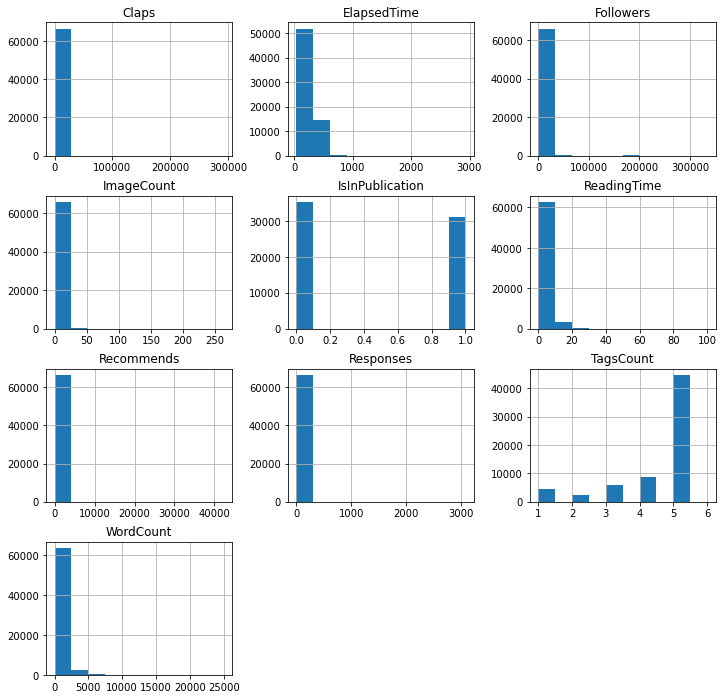

In [40]:
# set color
base_color = sb.color_palette()[0]

train_clean.hist(figsize=(12,12));


In [41]:
train_clean.describe()

ElapsedTime          Claps   ReadingTime    Recommends     Responses  \
count  66380.000000   66380.000000  66380.000000  66380.000000  66380.000000   
mean     215.558210     173.135026      3.981259     25.196113      0.902757   
std      116.136024    1891.890063      3.523158    277.391004     14.940658   
min       35.000000       0.000000      0.000000      0.000000      0.000000   
25%      117.000000       0.000000      2.000000      0.000000      0.000000   
50%      206.000000       6.000000      3.000000      2.000000      0.000000   
75%      305.000000      65.000000      5.000000      8.000000      0.000000   
max     2930.000000  291706.000000    100.000000  42288.000000   3076.000000   

          WordCount     TagsCount      Followers    ImageCount  \
count  66380.000000  66380.000000   66380.000000  66380.000000   
mean     922.495089      4.299940    1776.915954      3.550136   
std      871.067923      1.203037   13029.953176      5.399172   
min        0.000000      1.000000       0.000000      0.000000   
25%      421.000000      4.000000       8.000000      1.000000   
50%      720.000000      5.000000      53.000000      2.000000   
75%     1158.000000      5.000000     324.000000      4.000000   
max    24964.000000      6.000000  333655.000000    263.000000   

       IsInPublication  
count     66380.000000  
mean          0.467972  
std           0.498977  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000

Let's have a closer look at the claps by limiting it with 2000.

In [42]:
claps2k = train_clean[train_clean['Claps'] < 2000]


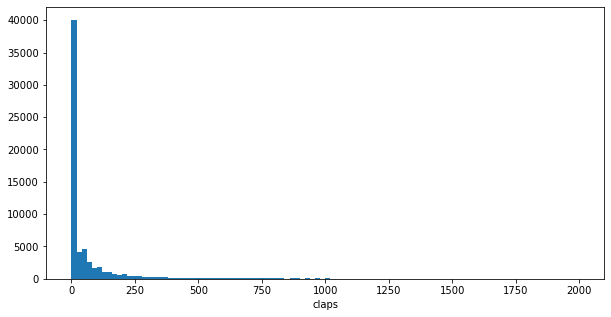

In [43]:
plt.figure(figsize = [10, 5])
plt.hist(data = claps2k, x = 'Claps', bins=100);
plt.xlabel('claps');

In [44]:
train_clean['Claps'].quantile([0.80, 0.85, 0.90, 0.95, 0.99])

0.80     100.00
0.85     150.00
0.90     247.00
0.95     540.00
0.99    2451.05
Name: Claps, dtype: float64

In [45]:
(train_clean[train_clean['Claps'] == 0]).shape[0]

20858

In [46]:
(train_clean[train_clean['Claps'] > 5000]).shape[0]

292

#### Oversampling and Undersampling

So most of the variables especially our target variable Claps are extremely skewed. If we look at our target variable number of claps, see that most of the posts (20858) didn't get any claps. The maximum value is almost 300k but the number of articles that get more than 5000 claps is only 292. So the data is unbalanced and we should do some work to balance the data.

We first remove 60 percent of the posts with zero claps[4]. Since the number of posts with higher claps are vey low we don't want to truncate those data. It looks like a good option to oversample the articles with claps more than 5000 roughly by 5 times. This will add 1500 rows to our dataframe. 

In [47]:
# inspired from https://github.com/warsihas/ADAMS_medium_clap_predict/blob/master/ADAMS_final4.ipynb

# Remove 60 percent of the articles that get zero claps
train_clean = train_clean.drop(train_clean[train_clean['Claps'] == 0].sample(frac=.6).index)


In [48]:
# Oversample the articles with claps more than 5000. It is roughly 5 times the existing ones
oversample = train_clean[train_clean['Claps'] > 5000].sample(1500, replace = True)
train_clean = pd.concat([train_clean, oversample], axis=0)

In [49]:
train_clean['Claps'].quantile([0.80, 0.85, 0.90, 0.95, 0.99])

0.80      156.0
0.85      240.0
0.90      439.0
0.95     1358.0
0.99    12366.0
Name: Claps, dtype: float64

For oversampling, we first tried 'smogn' to apply Synthetic Minority Over-Sampling Technique, but couln't get nicer results. We used the following code:

#### Scaling

Since the distributions are highly skewed, we apply log transformation to the variables: Claps, Responses, Followers, ReadingTime, WordCount, ElapsedTime, Recommends. It doesn't remove but reduce the skewness.

In [50]:
train_clean['logClaps'] =  train_clean['Claps'].apply(lambda x: np.log(x + 1)) 
train_clean['logResponses'] = train_clean['Responses'].apply(lambda x: np.log(x + 1)) 
train_clean['logFollowers'] = train_clean['Followers'].apply(lambda x: np.log(x + 1)) 
train_clean['logReadingTime'] = train_clean['ReadingTime'].apply(lambda x: np.log(x + 1)) 
train_clean['logWordCount'] = train_clean['WordCount'].apply(lambda x: np.log(x + 1)) 
train_clean['logElapsedTime'] = train_clean['ElapsedTime'].apply(lambda x: np.log(x + 1)) 
train_clean['logRecommends'] = train_clean['Recommends'].apply(lambda x: np.log(x + 1)) 


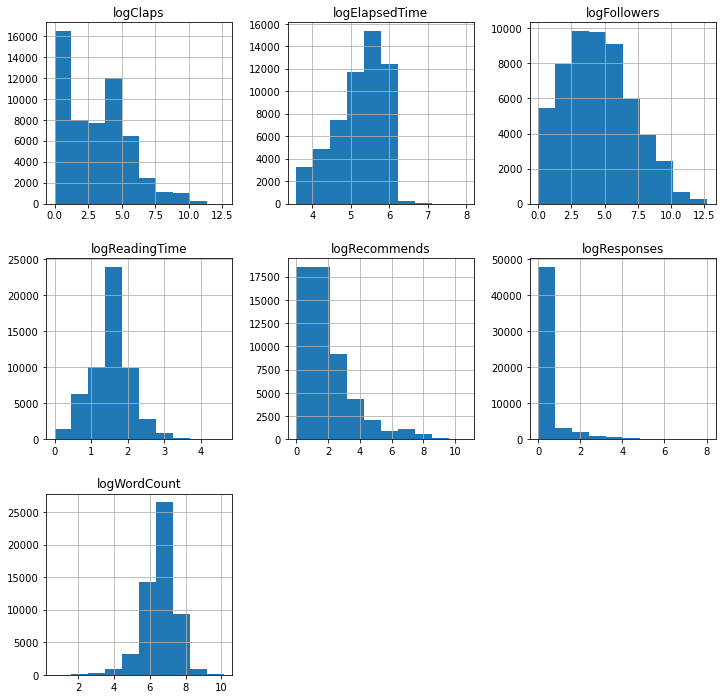

In [51]:
train_clean[['logClaps','logRecommends','logResponses', 
             'logReadingTime','logElapsedTime', 'logWordCount', 'logFollowers']].hist(figsize=(12,12));

### Bivariate Analysis

To look at the relationships more closely we provide the correlation plot.

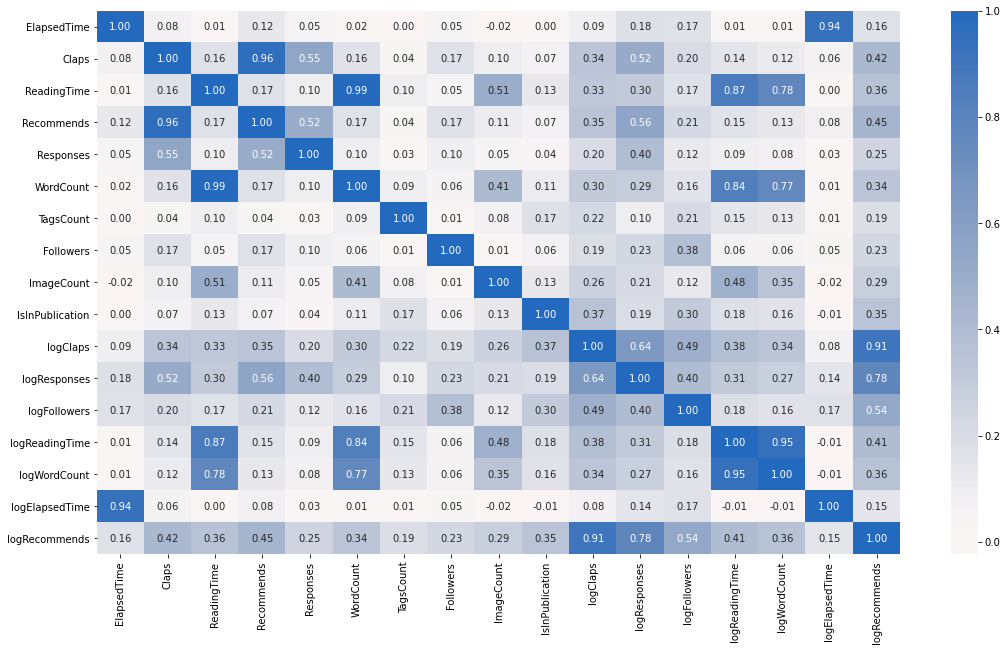

In [52]:
# correlation plot
plt.figure(figsize = [18, 10]);
sb.heatmap(train_clean.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0);

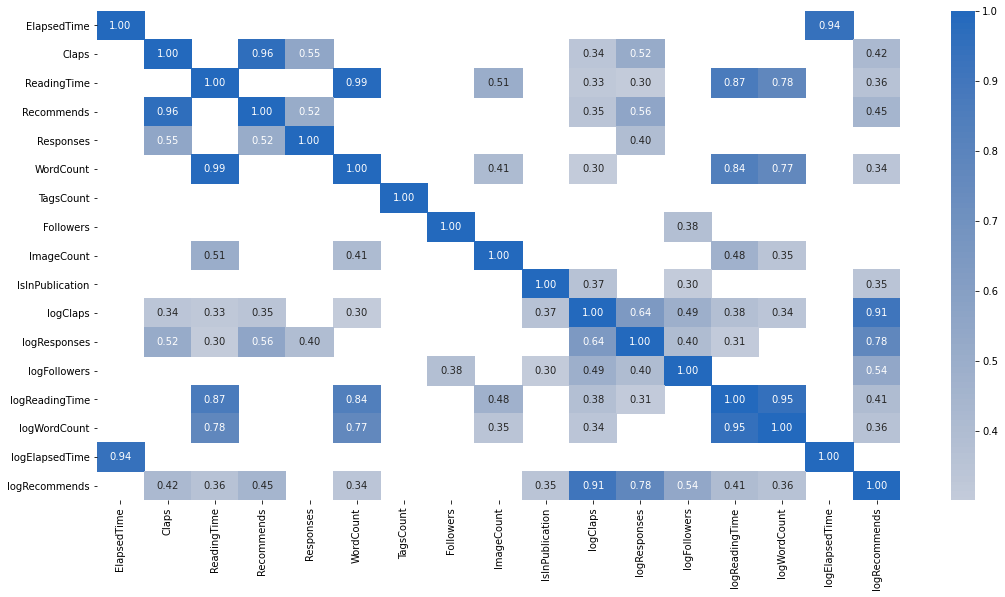

In [53]:
# correlation plot
plt.figure(figsize = [18, 9]);
sb.heatmap(train_clean.corr()[(train_clean.corr() >= 0.30) | (train_clean.corr() <= -0.30)],
                            annot=True,  fmt = '.2f', cmap = 'vlag_r', center = 0);


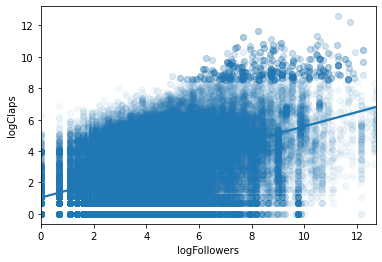

In [54]:
sb.regplot(data = train_clean, x = 'logFollowers', y = 'logClaps', scatter_kws = {'alpha' : 1/20});


Since there are a lot of points in the same area, we get a sample from the all population and have a new scatter plot.



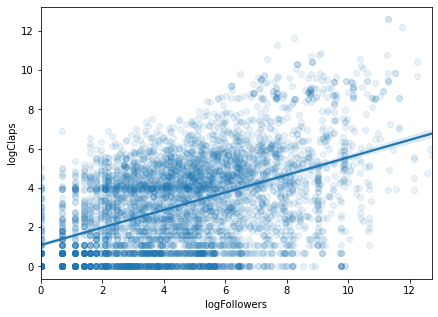

In [55]:
plt.figure(figsize = (7,5))
sb.regplot(data = train_clean.sample(5000), x = 'logFollowers', y = 'logClaps', scatter_kws = {'alpha' : 1/10});


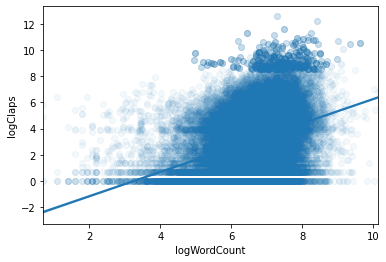

In [56]:
sb.regplot(data = train_clean, x = 'logWordCount', y = 'logClaps', scatter_kws = {'alpha' : 1/20});


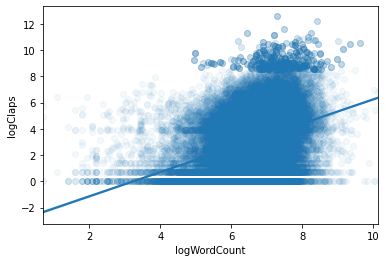

In [112]:
sb.regplot(data = train_clean, x = 'logWordCount', y = 'logClaps', scatter_kws = {'alpha' : 1/20});


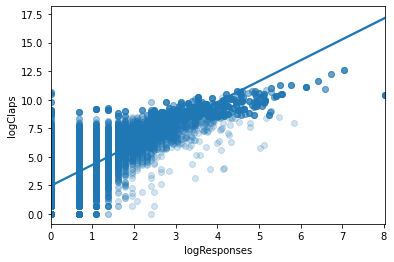

In [115]:
sb.regplot(data = train_clean, x = 'logResponses', y = 'logClaps', scatter_kws = {'alpha' : 1/5});


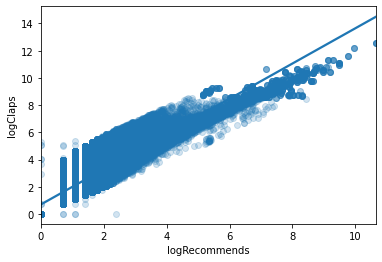

In [116]:
sb.regplot(data = train_clean, x = 'logRecommends', y = 'logClaps', scatter_kws = {'alpha' : 1/5});


It makes more sense to work with the log scaled values. There are high correlation between logClaps and logRecommends but Recommends column is not present in the test dataframe. The other variables logResponses, LogFollowers, logReadingTime, logWordCount, IsInPublication also worth to consider in our model.  

## Regression with Keras 

### First Regression

Since our aim is to predict a continious value we will use regression. For the first training model that will perform regression using Keras, we decided to take logResponses, LogFollowers, logWordCount, IsInPublication variables as our input.

In [61]:
from sklearn.model_selection import train_test_split

# split data into train and test set
trainX, testX, trainY, testY = train_test_split(train_clean[['logFollowers' ,'logWordCount', 'logResponses', 'logRecommends',
                                                             'IsInPublication']], train_clean['logClaps'], test_size=0.25, 
                                                              random_state=111)


In [62]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
seed = 111

#set up the name of the model and its type
model = Sequential()

# Start adding layers one by one: 
model.add(Dense(128,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros',
                input_shape=(trainX.shape[1],))) #first hidden layer size, i.e. number of features
model.add(Dropout(0.1))
# One more layer with the same configuration
model.add(Dense(128, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros')) 
model.add(Dropout(0.1))


# And finally the output layer
model.add(Dense(1, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros')) 

######################let's see how our architecture looks like (also very helpful to learn how many parameters will be trained and compare to
#the size of your training set)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


In [63]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import EarlyStopping


#opt = optimizers.SGD(lr=0.01)
#loss="mean_absolute_percentage_error"
opt = Adam(lr=1e-3, decay=1e-3 / 30)
model.compile(loss = 'mse', optimizer=opt, metrics=['mse'])
# train the model
print("[INFO] training model...")

batch_size = 64 #1 for online SGD
epochs = 30

cb=EarlyStopping(monitor='val_loss', min_delta=0.1, verbose=0, patience=10, restore_best_weights=True) #difference of
#loss is below min_delta, it is quantified as no improvement


#And now we fit the model (that is the training part), mind that saving it to the 
# variable will help you retrieve and analyse the training history
story = model.fit(trainX, trainY,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(testX, testY), #OR validation_split=0.3
                    callbacks=[cb]
                 )

[INFO] training model...
Epoch 1/30
649/649 [==============================] - 1s 1ms/step - loss: 4.8487 - mse: 4.8487 - val_loss: 0.9256 - val_mse: 0.9256
Epoch 2/30
649/649 [==============================] - 1s 986us/step - loss: 1.0458 - mse: 1.0458 - val_loss: 0.9257 - val_mse: 0.9257
Epoch 3/30
649/649 [==============================] - 1s 913us/step - loss: 0.9471 - mse: 0.9471 - val_loss: 0.9507 - val_mse: 0.9507
Epoch 4/30
649/649 [==============================] - 1s 912us/step - loss: 0.9164 - mse: 0.9164 - val_loss: 0.8693 - val_mse: 0.8693
Epoch 5/30
649/649 [==============================] - 1s 885us/step - loss: 0.8995 - mse: 0.8995 - val_loss: 0.8117 - val_mse: 0.8117
Epoch 6/30
649/649 [==============================] - 1s 908us/step - loss: 0.8863 - mse: 0.8863 - val_loss: 0.9444 - val_mse: 0.9444
Epoch 7/30
649/649 [==============================] - 1s 906us/step - loss: 0.8731 - mse: 0.8731 - val_loss: 0.8051 - val_mse: 0.8051
Epoch 8/30
649/649 [===================

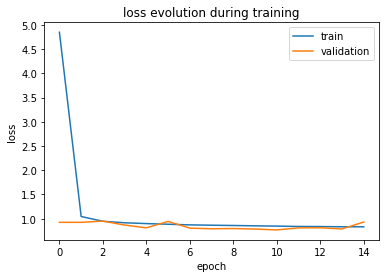

In [64]:
plt.plot(story.history['loss'])
plt.plot(story.history['val_loss'])
plt.title('loss evolution during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [65]:
score = model.evaluate(testX, testY, verbose=0)
score

[0.8117164373397827, 0.8117164373397827]

In [66]:
preds = model.predict(testX)

In [67]:
preds_exp = np.exp(preds.flatten())
y_test_exp = np.exp(testY)

diff = np.subtract(preds_exp, y_test_exp)
percentDiff = (diff / y_test_exp) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 63.35%, std: 77.66%


Text(0.5, 1.0, 'Predicted vs True values')

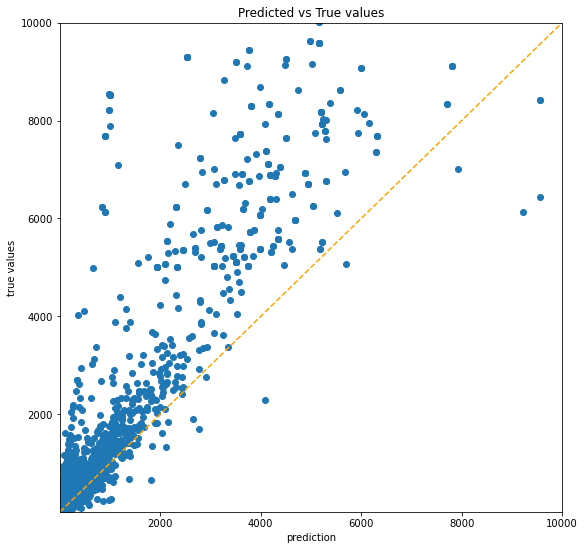

In [68]:
size = 10_000

plt.figure(figsize=(9, 9))
plt.scatter(preds_exp, y_test_exp)
plt.plot(np.linspace(0,size,size), np.linspace(0,size,size), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(10,size)
plt.ylim(10,size)
plt.title('Predicted vs True values')

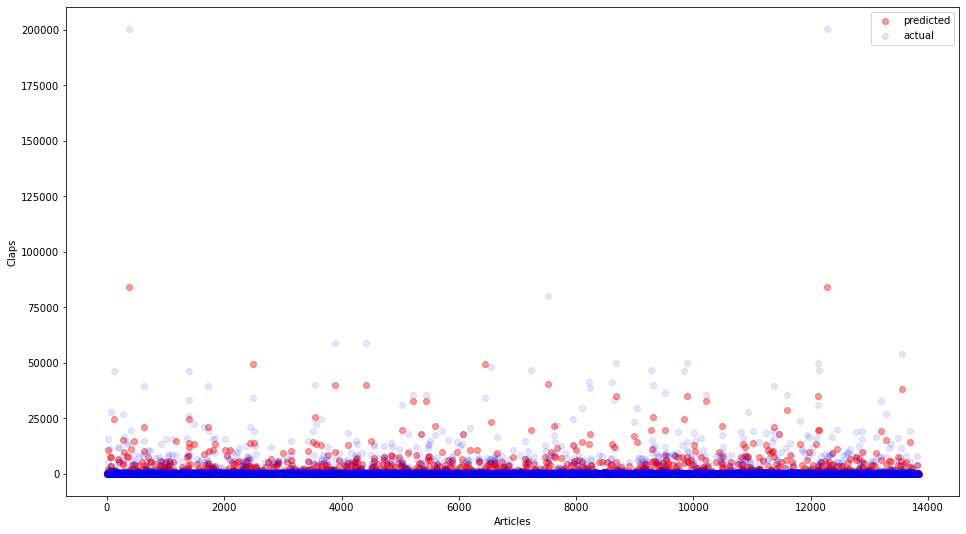

In [69]:
# The idea and the code of this graph is taken from https://github.com/warsihas/ADAMS_medium_clap_predict/blob/master/ADAMS_final4.ipynb

x_range = range(0, len(y_test_exp))

plt.figure(figsize=(16, 9))
plt.scatter(x_range, preds_exp, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test_exp, color = 'b', alpha = 0.1, label = 'actual')
plt.legend()
plt.xlabel('Articles')
plt.ylabel('Claps')
plt.show()

It looks like the model is able to make predictions for the articles that get smaller than 50000 claps. There are pretty good predictions between 25000 and 50000 claps which be can consider as outliers.

### Second Regression

Since we couldn't find Followers and Recommends data for the Test data, will continue with the other features.

In [70]:

# split data into train and test set
trainX, testX, trainY, testY = train_test_split(train_clean[['logWordCount', 'logResponses','IsInPublication']], 
                                                train_clean['logClaps'], test_size=0.25, random_state=111)

In [71]:
#set up the name of the model and its type
model = Sequential()

# Start adding layers one by one: 
model.add(Dense(64,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros',
                input_shape=(trainX.shape[1],))) #first hidden layer size, i.e. number of features
model.add(Dropout(0.1))
# One more layer with the same configuration
model.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros')) 
model.add(Dropout(0.1))


# And finally the output layer
model.add(Dense(1, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros')) 

######################let's see how our architecture looks like (also very helpful to learn how many parameters will be trained and compare to
#the size of your training set)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [72]:

from tensorflow.keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import EarlyStopping


#opt = optimizers.SGD(lr=0.01)
#loss="mean_absolute_percentage_error"
opt = Adam(lr=1e-3, decay=1e-3 / 30)
model.compile(loss = 'mse', optimizer=opt, metrics=['mse'])
# train the model
print("[INFO] training model...")

batch_size = 64 
epochs = 30

cb=EarlyStopping(monitor='val_loss', min_delta=0.1, verbose=0, patience=10, restore_best_weights=True) #difference of
#loss is below min_delta, it is quantified as no improvement


story = model.fit(trainX, trainY,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(testX, testY), #OR validation_split=0.3
                    callbacks=[cb]
                 )

[INFO] training model...
Epoch 1/30
649/649 [==============================] - 1s 1ms/step - loss: 4.0492 - mse: 4.0492 - val_loss: 2.8252 - val_mse: 2.8252
Epoch 2/30
649/649 [==============================] - 1s 782us/step - loss: 3.1091 - mse: 3.1091 - val_loss: 2.9242 - val_mse: 2.9242
Epoch 3/30
649/649 [==============================] - 0s 759us/step - loss: 3.0328 - mse: 3.0328 - val_loss: 2.7903 - val_mse: 2.7903
Epoch 4/30
649/649 [==============================] - 0s 759us/step - loss: 3.0069 - mse: 3.0069 - val_loss: 2.8527 - val_mse: 2.8527
Epoch 5/30
649/649 [==============================] - 0s 757us/step - loss: 2.9801 - mse: 2.9801 - val_loss: 2.8142 - val_mse: 2.8142
Epoch 6/30
649/649 [==============================] - 0s 757us/step - loss: 2.9716 - mse: 2.9716 - val_loss: 2.8050 - val_mse: 2.8050
Epoch 7/30
649/649 [==============================] - 0s 761us/step - loss: 2.9514 - mse: 2.9514 - val_loss: 2.7605 - val_mse: 2.7605
Epoch 8/30
649/649 [===================

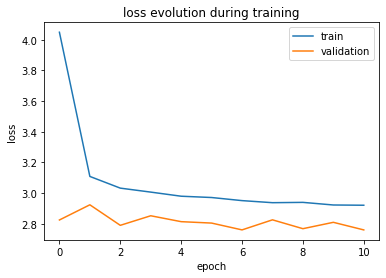

In [73]:
plt.plot(story.history['loss'])
plt.plot(story.history['val_loss'])
plt.title('loss evolution during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [74]:
score = model.evaluate(testX, testY, verbose=0)
score

[2.825193166732788, 2.825193166732788]

In [75]:
preds = model.predict(testX)

Text(0.5, 1.0, 'Predicted vs True values')

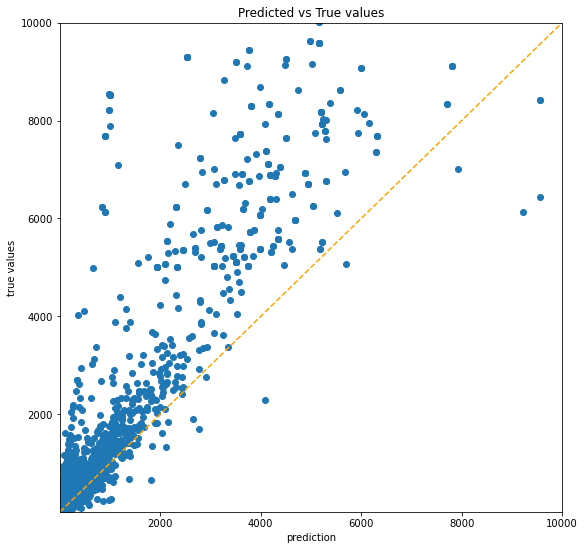

In [76]:
size = 10_000

plt.figure(figsize=(9, 9))
plt.scatter(preds_exp, y_test_exp)
plt.plot(np.linspace(0,size,size), np.linspace(0,size,size), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(10,size)
plt.ylim(10,size)
plt.title('Predicted vs True values')

In [77]:
preds_exp = np.exp(preds.flatten())
y_test_exp = np.exp(testY)

diff = np.subtract(preds_exp, y_test_exp)
percentDiff = (diff / y_test_exp) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 229.91%, std: 569.44%


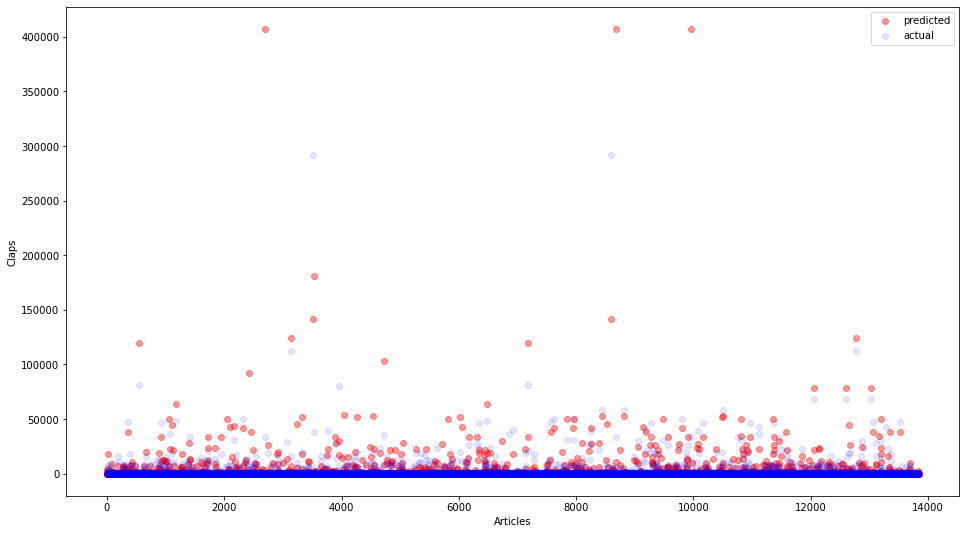

In [221]:
x_range = range(0, len(y_test_exp))

plt.figure(figsize=(16, 9))
plt.scatter(x_range, preds_exp, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test_exp, color = 'b', alpha = 0.1, label = 'actual')
plt.legend()
plt.xlabel('Articles')
plt.ylabel('Claps')
plt.show()

Comparing the first regression model, the mean and standard deviation of the absolute percentage difference between the predicted and the true values are much higher. One reason might be the exclusion of the variable logRecommends because it was highly correlated with logClaps. 

Still, the model can predict some outliers between 50000 and 100000 claps.

## Text Preprocessing

To prepare our text we will use nltk package and follow these text preprocessing steps:

- Remove HTML tags
- Remove urls 
- Remove non-alphabetic characters including special characters and numbers
- Remove single letters
- Expand Contractions
- Remove extra whitespaces
- Remove special characters
- Convert all letters to lower case
- Convert number words to numeric form
- Tokenize the text
- Remove stopwords
- Lemmatization

In [79]:
pd.set_option('max_colwidth', -1) 

train_clean.Text.head()

<ipython-input-79-42fd093a0be8>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


0     Private Business, Government and Blockchain\n\nA major private IT company implements blockchain, artificial intelligence, and Internet of Things to optimize and improve high technology workflow. The representatives of a major state structure from the same country like this experiment so much they decide to use it in their work and conclude an agreement with the IT giant. This is an ideal example of interaction between private business and the state regarding blockchain, don’t you think? What is even better is that this story is real: in South Korea a local customs office has signed the respective partnership agreement with Samsung. I believe that the near-term development of blockchain will be built on just such examples of cooperation. In a world where all the best technological decisions are copied at supersonic speed, one cannot remain behind the trends for long. That’s why I’m confident that blockchain and other crypto technologies will soon be adopted around the world. In th

In [80]:
#Draw a sample size to save time
# sample_size = 100
# idx = np.random.randint(0, high = train_clean.shape[0], size = sample_size)
# train_clean = train_clean.iloc[idx,:]
# train_clean.reset_index(inplace = True, drop = True)
# train_clean.head()

In the text preprocessing function, we will use lemmatization. Since lemmatization supports different forms of a word, such as noun, verb, etc. We write a helper function that uses the POS tagger of the NLTK toolkit. So we can select a right grammatical form for the lemmatizer.

In [81]:
# Code is taken from the Tutotial#11

# Lemmatize with POS tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)




Contractions are shortened version of words or syllables which are usually created by removing some part of the word in English language. For instance; 'do not', 'he will', 'must have' are converted into 'don't', 'he'll', 'must've'. If we don't convert those contractions to their original form then we will have words such as dont, hell, mustve which either doesn't have a meaning or can be mixed with another meaningful word (in this case hell)[5].

In [82]:
# https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/nlp%20proven%20approach

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

The following function will clean the articles. It receives as input a set of texts, iterate over that set and clean each article. Then we store the cleaned reviews as a list of lists.

In [83]:
lemmatizer = WordNetLemmatizer()

In [84]:
def clean_articles(df):
    texts = []

    for text in df:
        
        #remove html content
        clean_text = BeautifulSoup(text).get_text()
        
        #expand contractions
        clean_text = expand_contractions(clean_text)
        
        #remove urls
        clean_text = re.sub(r"http\S+", ' ', clean_text)

        #remove non-alphabetic characters
        clean_text = re.sub("[^a-zA-Z]"," ", clean_text)
        
        #remove single letters
        clean_text = re.sub(r"\b[a-zA-Z]\b", " ", clean_text) 
        
        #remove white spaces
        clean_text = re.sub(' +', ' ', clean_text)
    
        #tokenize the text
        words = word_tokenize(clean_text.lower())
        
        #remove stopwords
        stop_words = set(stopwords.words('english'))
        words_clean = [word for word in words if word not in stop_words]

        #lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words_clean]
    
        texts.append(lemma_words)

    return(texts)

In [85]:
from datetime import datetime

print("Started cleaning =", datetime.now().strftime("%H:%M:%S"))

Started cleaning = 23:19:34


In [86]:
# Clean Train text data
train_texts = clean_articles(train_clean.Text)


/Users/s.dane/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://icoratingblog.wordpress.com/2017/12/05/first-blog-post/

" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/s.dane/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://blog.juecell.in/2018/08/artificial-intelligence-living-with.html?m=1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [87]:
# Clean Test text data
test_texts = clean_articles(test_clean.Text)


In [88]:
print("Finished cleaning =", datetime.now().strftime("%H:%M:%S"))

Finished cleaning = 00:21:56


In [127]:
# Turn on the correct one
# data_files = ['articles_clean_sample.pkl', 'train_clean_sample.pkl']
data_files = ['articles_clean.pkl', 'train_clean.pkl']

# with open(data_files[0],'wb') as path_name:
#     pickle.dump(train_texts, path_name)

# with open(data_files[1],'wb') as path_name:
#     pickle.dump(train_clean, path_name)

#### Load already cleaned data

In [90]:
import pickle

# 'rb' specifies 'read (open in binary mode)'
# with open('headers_clean_s.pkl','rb') as path_name:
#     headers = pickle.load(path_name)
#     print(headers[1])

# Turn on the correct one
# data_files = ['articles_clean_sample.pkl', 'train_clean_sample.pkl']
data_files = ['articles_clean_final.pkl', 'train_clean_final.pkl']
    
# with open(data_files[0],'rb') as path_name:
#     train_texts = pickle.load(path_name)
#     print("Received cleaned train_texts: {}".format(len(train_texts)))
    
# with open(data_files[1],'rb') as path_name:
#     train_clean = pickle.load(path_name)
#     print("Received train_clean dataframe: {}".format(len(train_clean)))

I use the class Counter from the collections package to count word occurrences and see the most common words.

In [91]:
#https://github.com/Humboldt-WI/adams/blob/master/exercises/Ex10_word2vec/Ex10_word2vec.ipynb

# Loop through the words and update a counter keeping track of word counts
import collections

word_counter = collections.Counter()
for t in train_texts:
    for w in t:
        word_counter.update({w: 1})

In [92]:
word_counter.most_common(10)


[('data', 381087),
 ('use', 269580),
 ('learn', 243140),
 ('ai', 209999),
 ('model', 164627),
 ('one', 153321),
 ('make', 152092),
 ('machine', 138782),
 ('time', 138327),
 ('like', 125753)]


### Phrase detection
Gensim Phrases package finds common phrases (bigrams, trigrams, fourgrams..). In our case, it might be very useful to find phrases like "data science", "artificial intelligence", etc. Take 'data science' as an example. Word2Vec train one embedding for data and another one for science and add them to the vocabulary. To get better embeddings, we can add those phrases to the vocabulary by detecting them with Gensim.

Mikolov, et. al: “Distributed Representations of Words and Phrases and their Compositionality”

In [94]:
from gensim.models.phrases import Phrases

# Train a bigram model
bigram_model = Phrases(train_texts, min_count=100)


In [95]:
bigram_model[train_texts[0]]

['private',
 'business',
 'government',
 'blockchain',
 'major',
 'private',
 'company',
 'implement',
 'blockchain',
 'artificial_intelligence',
 'internet_thing',
 'optimize',
 'improve',
 'high',
 'technology',
 'workflow',
 'representative',
 'major',
 'state',
 'structure',
 'country',
 'like',
 'experiment',
 'much',
 'decide',
 'use',
 'work',
 'conclude',
 'agreement',
 'giant',
 'ideal',
 'example',
 'interaction',
 'private',
 'business',
 'state',
 'regard',
 'blockchain',
 'think',
 'even',
 'well',
 'story',
 'real',
 'south_korea',
 'local',
 'custom',
 'office',
 'sign',
 'respective',
 'partnership',
 'agreement',
 'samsung',
 'believe',
 'near',
 'term',
 'development',
 'blockchain',
 'built',
 'example',
 'cooperation',
 'world',
 'best',
 'technological',
 'decision',
 'copy',
 'supersonic',
 'speed',
 'one',
 'remain',
 'behind',
 'trend',
 'long',
 'confident',
 'blockchain',
 'crypto',
 'technology',
 'soon',
 'adopt',
 'around_world',
 'st_century',
 'would',
 '

In [96]:
# Tutorial#10

bigram_counter = collections.Counter()
for key in bigram_model.vocab.keys():
    if key.decode().find("_") >-1:
        bigram_counter[key] += bigram_model.vocab[key]

In [97]:
bigram_counter.most_common(10)

[(b'machine_learn', 92346),
 (b'artificial_intelligence', 49306),
 (b'neural_network', 39264),
 (b'deep_learn', 36139),
 (b'data_science', 34387),
 (b'data_scientist', 19169),
 (b'data_set', 13156),
 (b'big_data', 13021),
 (b'natural_language', 10067),
 (b'learn_algorithm', 9720)]

In [98]:
# Replace texts with their Phrased versions
train_texts = [bigram_model[text] for text in train_texts]

## Word2Vec Embeddings

Word2Vec provided by Mikolov et al. in 2013 and it is an efficient way of generating word embeddings[2]. This algorithm takes text corpus as an input and it gives a vector representation for each word as output. It detects the similarities by using cosine similarity between the words and groups them in the vectorspace. We can understand the relationships (semantic similarity) between the words by looking at those vectors.

Word2vec has two main learning algorithms, continuous bag-of-words and continuous skip-gram. While CBOW model predicts a word from its surrounding words, Skip-gram model takes a word as a focus and predicts the surrounding words. Although CBOW is faster, Skip-gram is more successful in finding infrequent words[6]. So, we will use Word2Vec with Skip-gram algorithm to train our own embeddings. 

![](https://user-images.githubusercontent.com/41328029/91761518-b4b0b200-ebdd-11ea-927e-26b1f921f773.png)



In [99]:
print("Starting Word2Vec =", datetime.now().strftime("%H:%M:%S"))

Starting Word2Vec = 00:24:33


In [100]:

from gensim.models import Word2Vec    

emb=300 #size of embedding dimension

# Train a Word2Vec model
model = Word2Vec(train_texts, 
                 min_count = 5,  #min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 window = 10,    #the size of context
                 iter = 50,      #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size = emb,     #size of embedding,
                 sg = 1,         #skipgram 
                 workers = 4)    #for parallel computing
#summarize the loaded model
print(model)
words=list(model.wv.vocab)

Word2Vec(vocab=60998, size=300, alpha=0.025)


In [101]:
embs="text_embeddings.txt"
model.wv.save_word2vec_format(embs, binary=False)

In [102]:
from datetime import datetime
print("Finished Word2Vec =", datetime.now().strftime("%H:%M:%S"))

Finished Word2Vec = 02:14:07


In [103]:
model.wv.most_similar("ai",topn=10)

[('artificial_intelligence', 0.8153278827667236),
 ('technology', 0.6071553230285645),
 ('intelligent', 0.536786675453186),
 ('ml', 0.5106256008148193),
 ('intelligence', 0.5071644186973572),
 ('machine_learn', 0.5063995122909546),
 ('today', 0.4974006414413452),
 ('believe', 0.49691325426101685),
 ('deep_learn', 0.4881736934185028),
 ('tech', 0.4821696877479553)]

In [104]:
model.wv.most_similar("data_science",topn=10)

[('data_scientist', 0.7438175082206726),
 ('machine_learn', 0.5899227857589722),
 ('analytics', 0.5446882247924805),
 ('career', 0.4943908452987671),
 ('statistic', 0.488251268863678),
 ('python', 0.48294028639793396),
 ('mathematics_statistic', 0.4782840609550476),
 ('course', 0.4728134274482727),
 ('visualization', 0.47098594903945923),
 ('sexiest_job', 0.4668840765953064)]

So the embeddings are not bad, almost all of them are meaningful.

In [105]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

In [106]:
from keras.preprocessing.text import Tokenizer

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_texts)
seq=tokenizer_obj.texts_to_sequences(train_texts)

In [107]:
longestText=max([len(s.split()) for s in train_clean["Text"]])
print(longestText)

23788


In [108]:
# max_len = longestText
max_len = 10000 # cap the maximum article word count

In [109]:
from keras.preprocessing.sequence import pad_sequences
padded=pad_sequences(seq, max_len, padding='post')

In [110]:
# From Tutorials
embeddings_index={}
with open("text_embeddings.txt") as loaded_embs:
    for line in loaded_embs:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:])
        embeddings_index[word]=coefs

In [111]:
embeddings_index["ai"]


array(['0.27114084', '-0.12146926', '-0.08324514', '-0.086435154',
       '-0.15985183', '0.17496419', '-0.17740038', '0.12796538',
       '-0.21499804', '0.030489147', '-0.003587756', '-0.018438747',
       '-0.05448925', '0.04405856', '-0.26008227', '-0.17618136',
       '-0.17107238', '0.20365633', '0.09341825', '0.23783883',
       '-0.26271644', '-0.06895075', '0.35034493', '-0.048481528',
       '0.0660015', '0.027827194', '0.019640462', '-0.21437143',
       '-0.20879124', '0.17895907', '-0.1821903', '-0.29969618',
       '0.29359347', '-0.02411787', '0.05210704', '0.32372174',
       '-0.028057812', '-0.11577557', '-0.14989299', '0.054309644',
       '-0.12302327', '0.059207145', '0.0075513646', '-0.06969173',
       '0.015166064', '0.0065470724', '0.10872791', '0.0579015',
       '0.033008117', '-0.094124384', '0.035869904', '0.3126522',
       '-0.050945967', '0.02451343', '-0.14390437', '-0.15680513',
       '0.26317582', '-0.056022536', '-0.057036307', '0.20247476',
       

In [112]:
word_index=tokenizer_obj.word_index
# here is the size of vocab/number of unique tokens
len(word_index)

196099

In [113]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words, emb))

In [114]:
for word, i in word_index.items():
    if i > num_words:
        continue
    try:
        embedding_vector=embeddings_index[word]
        # dealing with words that we have not embeddings for
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    except:
        print("Problem with word: {}".format(word))

# embedding_matrix is our lookup table
embedding_matrix.shape

Problem with word: autosomal
Problem with word: melodyannucros
Problem with word: bankrolling
Problem with word: proselytize
Problem with word: cordoned
Problem with word: subsides
Problem with word: weaponise
Problem with word: omniearth
Problem with word: siesta
Problem with word: multiband
Problem with word: savi
Problem with word: matriculate
Problem with word: goldie
Problem with word: cryptofinance
Problem with word: dossal
Problem with word: shulman
Problem with word: cointime
Problem with word: regexptokenizer
Problem with word: akata
Problem with word: catia
Problem with word: scanse
Problem with word: wlan
Problem with word: dspace
Problem with word: rhapsody
Problem with word: licensable
Problem with word: microblogs
Problem with word: oshbot
Problem with word: jucikas
Problem with word: heriot
Problem with word: clifton
Problem with word: decarbonise
Problem with word: grayscaling
Problem with word: undereducated
Problem with word: biller
Problem with word: nutonian
Problem

(196100, 300)

## Multiple inputs and mixed data with Keras

In this part, I use mixed data (numerical and textual data) to train an end-to-end Keras model. To be able to work with multiple inputs I use Keras functional API which allows us to define much more complex models that are non-sequential.

There are two different kind of networks, the first one is Multi-layer Perceptron (MLP) who takes numerical features as input and the second one Convolutional Neural Network (CNN) who takes text as an input. Then I concatenate these networks together to form the final multi-input Keras model.

There is not a regression output of the MLP, regression is performed in the last step of the entire multi-input, mixed data network.

![](https://user-images.githubusercontent.com/41328029/91761525-b8443900-ebdd-11ea-9c82-4c116f19b590.png)



In [115]:
## Multi-layer Perceptron (MLP) Model# Split all the data
# First the attributes for the MLP Model
# Second the padded array representing the text in the article
# Third is the clap values for testing


trainAttrX, testAttrX, trainTextsX, testTextsX, trainY, testY = train_test_split(
    train_clean[['logWordCount', 'logResponses', 'IsInPublication']],
    padded,
    train_clean['logClaps'], test_size=0.25, random_state=111
)

In [116]:
embedding_layer=Embedding(num_words, #size of vocab
                          emb, #size of embedding 
                          embeddings_initializer=Constant(embedding_matrix), #weights to start with, and not touch during training
                          input_length=max_len, 
                          trainable=False  # do no update these weights
                         )

### Multi-layer Perceptron (MLP) Model

In [117]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
seed = 111

#set up the name of the model and its type
mlp = Sequential()

# Start adding layers one by one: 
mlp.add(Dense(64,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros',
                input_shape=(trainAttrX.shape[1],))) #first hidden layer size, i.e. number of features
mlp.add(Dropout(0.1))
# # One more layer with the same configuration
mlp.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
                bias_initializer='zeros')) 
mlp.add(Dropout(0.1))


# One more layer with the same configuration
# mlp.add(Dense(64, activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
#                 bias_initializer='zeros')) 
# mlp.add(Dropout(0.1))


# And finally the outout layer
# mlp.add(Dense(1, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), #initialisation of weights, 
#                 bias_initializer='zeros')) 

######################let's see how our architecture looks like (also very helpful to learn how many parameters will be trained and compare to
#the size of your training set)
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
Total params: 4,416
Trainable params: 4,416
Non-trainable params: 0
_________________________________________________________________


### Convolutional Neural Network (CNN) Model

CNN is class of deep neural networks which is mostly used for image classification but it is also very powerful and popular in text classification problems. CNNs are consist of several layers of convolutions with nonlinear activation functions like ReLU or tanh. In feedforward neural networks there is fully connected layers that connect each input neuron to each output neuron in the next layer. Differently in CNNs, the convolution layers are used over the input layer to compute the output. There are also subsampling (pooling) layers and they are usually used after convolutional layers. Their job is to reduce the feature map dimensionality for computational efficiency[8].

![](https://user-images.githubusercontent.com/41328029/91761520-b5e1df00-ebdd-11ea-86ec-f9464581039d.png)

Convolution layers are desinged to find spatial patterns in an image by sliding a small kernel window over an image. In text classification, we view document as an image data set, sentences of length 𝑛 as individual images. It gives 𝑛 × 𝑑 'sentence' matrix where 𝑑 is embedding dimension. In convolutional layer, we apply filters of size 𝑠 × 𝑑 where 𝑠 denotes kernel size (length of sequences). We can again consider a convolutional kernel as a sliding window that looks at embeddings for multiple words. The width of the kernel is embedding dimension and the height of the kernel is the number of embeddings it sees at one[9].

![](https://user-images.githubusercontent.com/41328029/91761523-b7aba280-ebdd-11ea-899c-01b5a25fffb7.png)


Even though, RNNs are better fit for NLP tasks CNNs are much faster so we will use CNN for NLP part of this task. In 1D convolution layer, we use 128 filters with kernel size 5 to capture patterns in sequential groups of 5 words and the relu activation function. Since the embedding dimension is 300 the dimensions of the convolutional kernel will be 5x300.


We also tried CNN with multiple kernels like in the paper of (Yoon Kim, 2014) but it didn't improve our results so decided not to put it here[10].



In [118]:
2from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense

# embedding_layer=Embedding(num_words, #size of vocab
#                           emb, #size of embedding 
#                           embeddings_initializer=Constant(embedding_matrix), #weights to start with, and not touch during training
#                           input_length=max_len, 
#                           trainable=False  # do no update these weights
#                          )

cnn = Sequential()
cnn.add(embedding_layer)
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))

# cnn.add(Dense(1, activation='linear'))
# cnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10000, 300)        58830000  
_________________________________________________________________
conv1d (Conv1D)              (None, 9996, 128)         192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4998, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 639744)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                40943680  
Total params: 99,965,808
Trainable params: 41,135,808
Non-trainable params: 58,830,000
_________________________________________________________________


### Concatenate Two Branches

In [119]:
from keras.layers import concatenate
from tensorflow.keras.models import Model

combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(10, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [21]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

opt = Adam(lr=1e-3, decay=1e-3 / 10)
model.compile(loss="mse", optimizer=opt, metrics=['mse'])

cb=EarlyStopping(monitor='val_loss', min_delta=0.1, verbose=0, patience=10, restore_best_weights=True) #difference of

# train the model
print("[INFO] training model...")
story = model.fit(
    x=[trainAttrX, trainTextsX], y=trainY,
    validation_data=([testAttrX, testTextsX], testY),
    epochs=10, batch_size=56, callbacks=[cb])


# make predictions on the testing datay
print("[INFO] predicting claps...")
preds = model.predict([testAttrX, testTextsX])

[INFO] training model...
Epoch 1/10
742/742 [==============================] - 244s 329ms/step - loss: 3.7705 - mse: 3.7705 - val_loss: 2.6195 - val_mse: 2.6195
Epoch 2/10
742/742 [==============================] - 251s 338ms/step - loss: 2.6842 - mse: 2.6842 - val_loss: 2.5190 - val_mse: 2.5190
Epoch 3/10
742/742 [==============================] - 246s 331ms/step - loss: 2.2729 - mse: 2.2729 - val_loss: 2.4561 - val_mse: 2.4561
Epoch 4/10
742/742 [==============================] - 245s 330ms/step - loss: 1.4955 - mse: 1.4955 - val_loss: 2.7765 - val_mse: 2.7765
Epoch 5/10
742/742 [==============================] - 245s 330ms/step - loss: 0.8085 - mse: 0.8085 - val_loss: 3.1787 - val_mse: 3.1787
Epoch 6/10
742/742 [==============================] - 245s 331ms/step - loss: 0.4968 - mse: 0.4968 - val_loss: 2.9397 - val_mse: 2.9397
Epoch 7/10
742/742 [==============================] - 247s 333ms/step - loss: 0.3522 - mse: 0.3522 - val_loss: 3.0495 - val_mse: 3.0495
Epoch 8/10
742/742 [===

In [22]:
preds_exp = np.exp(preds.flatten())
y_test_exp = np.exp(testY)

diff = np.subtract(preds_exp, y_test_exp)
percentDiff = (diff / y_test_exp) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 357.48%, std: 1215.47%


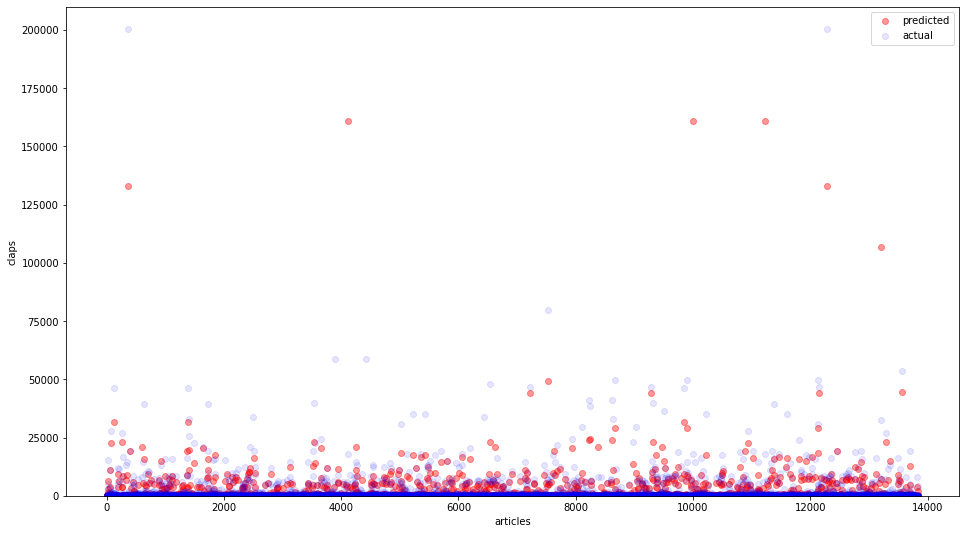

In [31]:
y_limit = 210_000
x_range = range(0, len(y_test_exp))

plt.figure(figsize=(16, 9))
plt.scatter(x_range, preds_exp, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test_exp, color = 'b', alpha = 0.1, label = 'actual')
plt.legend()

plt.xlabel('articles')
plt.ylabel('claps')
plt.ylim(0,y_limit)
plt.show()

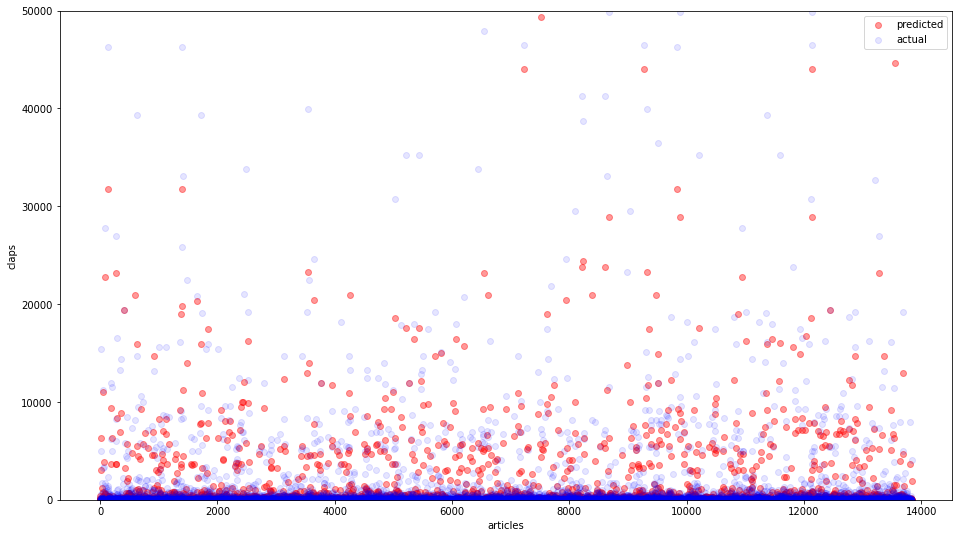

In [30]:
x_range = range(0, len(y_test_exp))
y_limit = 50_000

plt.figure(figsize=(16, 9))
plt.scatter(x_range, preds_exp, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test_exp, color = 'b', alpha = 0.1, label = 'actual')
plt.legend()
plt.ylim(0,y_limit)

plt.xlabel('articles')
plt.ylabel('claps')
plt.show()

In [27]:
y_test_exp.max()

200358.00000000015

Text(0.5, 1.0, 'Predicted vs True values')

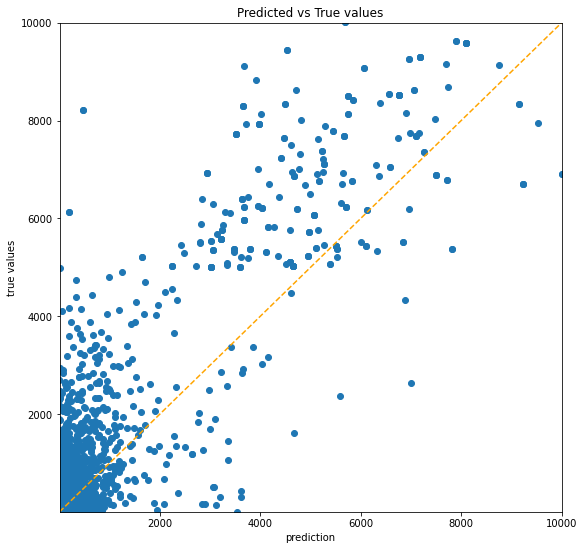

In [32]:
size = 10_000
plt.figure(figsize=(9, 9))
plt.scatter(preds_exp, y_test_exp)
plt.plot(np.linspace(0,size,size), np.linspace(0,size,size), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(10,size)
plt.ylim(10,size)
plt.title('Predicted vs True values')

In [33]:
preds_exp.max()

826518.9

In [34]:
y_test_exp.max()

200358.00000000015

The multi input model predicted very high values. However they don't seem right. It predicted some values more accurately smaller than 50000 claps. In additon, the mean and standard deviation of the absolute percentage difference is high. One possible reason is the existence of the otliers and the imbalance of the data.

## Discussion

When we look at the comparison of prediction and true value graphs, we see that that the multi input model gives better predictions between the values 5000 and 10000 than regression model. However still, the results of the mixed model are not satisfactory.

One possible reason is the feature selection. It requires more investigation and data scraping might be one option to create more columns in the test data frame. We also considered tag prediction using text classification but in the train data set there were 19278 different tags. Grouping them might be a good idea and would be a future task.

Another reason might be the selection of hyperparemeters. We used random search to find the best result but grid search might find more effective parameters. Overfitting is one other problem, we added dropout layers to overcome this issue but still couldn't be successful.
 
We also created a CNN model with only text input but its predictions were worse then these results. One other model that we created was the multi input data that takes logRecommends and logFollowers features in addition to the existing variables and text as input and its predictions were better than our final results.

We choose to work with CNNs since they are faster than RNNs and also it looked more challenging to understand and apply it to the text data but RNNs might give better results and it will be future work.

## Submission

In [58]:
from keras.preprocessing.sequence import pad_sequences

# The test data is already cleaned and lemmatized. We will continue with tokenizing and padding
testPadded = pad_sequences(tokenizer_obj.texts_to_sequences(test_texts), max_len, padding='post')
testPadded

array([[  503,   653,   379, ...,     0,     0,     0],
       [ 3713,  1982,  2288, ...,     0,     0,     0],
       [ 1631,  1039,  7268, ...,     0,     0,     0],
       ...,
       [  356,   970,  1849, ...,     0,     0,     0],
       [ 8759,   356, 37895, ...,     0,     0,     0],
       [  119,   356,   143, ...,     0,     0,     0]], dtype=int32)

In [72]:
submission_preds = model.predict([test_clean[['logWordCount', 'logResponses', 'IsInPublication']], testPadded])

In [73]:
submission_preds = np.exp(submission_preds) - 1

In [75]:
submission_preds.max()

97351.766

In [76]:
submission_preds.mean()

1252.3652

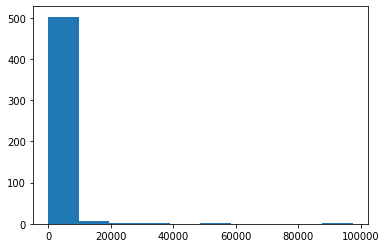

In [77]:
plt.hist(submission_preds);

In [80]:
test_clean['Claps'] = pd.DataFrame(submission_preds)
submission = test_clean[['index', 'Claps']]
submission.head()

index         Claps
0      0  58089.980469
1      1  32537.728516
2      2   1378.759277
3      5  26495.343750
4      7    211.442368

In [81]:
submission.Claps.describe()

count      514.000000
mean      1252.364990
std       6993.966309
min          0.112695
25%         23.886117
50%        101.225586
75%        395.534973
max      97351.765625
Name: Claps, dtype: float64

In [83]:
submission.to_csv('final_submission.csv', index=False)

## References



[1] https://en.wikipedia.org/wiki/Medium_(website)

[2] Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado and Jeffrey Dean, Distributed Representations of Words and Phrases and their Compositionality, Oct. 16, 2013

[3] Adrian Rosebrock, Keras: Multiple Inputs and Mixed Data - https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

[4] https://github.com/warsihas/ADAMS_medium_clap_predict/blob/master/ADAMS_final4.ipynb

[5] Dipanjan Sarkar, Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP -https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

[6] https://code.google.com/archive/p/word2vec/

[7] Tomas Mikolov, Quoc V. Le, Ilya Sutskever, Exploiting Similarities among Languages for Machine Translation, Sept. 17, 2013

[8] Denny Britz, Understanding Convolutional Neural Networks for NLP - http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

[9] Cezanne Camacho, CNNs for Text Classification - https://cezannec.github.io/CNN_Text_Classification/

[10] Yoon Kim, Convolutional Neural Networks for Sentence Classification, Sept. 3, 2014

https://github.com/Humboldt-WI/adams





